In [1]:
import pandahouse
import numpy as np
import pandas as pd

In [2]:
from scipy import stats

In [3]:
import seaborn as sns

При проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом. Для этого нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

Симуляция, как будто мы провели n_t АА-тестов в 2 группах с n_s уникальных пользователей

In [4]:
def run_test(group1, group2, n_t, n_s):
    pvalue_array = []
    for i in range(n_t):
        s1 = group1.sample(n_s)
        s2 = group2.sample(n_s)
        pvalue = stats.ttest_ind(s1, s2, equal_var=False)
        pvalue_array.append(pvalue[1])
    pvalue_array = np.array(pvalue_array)
    return pvalue_array

In [5]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'password',
    'user': 'student',
    'database': 'simulator'
}

Данные АА-теста с '2022-07-06' по '2022-07-12'.

In [6]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions  
WHERE toDate(time) between '2022-07-06' and '2022-07-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [7]:
df = pandahouse.read_clickhouse(q, connection=connection)

Запускаем симуляцию 10000 АА-тестов по 500 пользователей в каждой группе.

In [8]:
tresult = run_test(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, 10000, 500)

In [9]:
df = pd.DataFrame(tresult, columns=['pvalue'])

Построим гистограмму распределения получившихся 10000 p-values.

<AxesSubplot:ylabel='Count'>

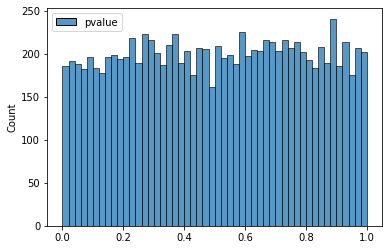

In [10]:
sns.histplot(data = df, bins = 50)

Посчитаем, какой процент p values оказался меньше либо равен 0.05.

In [11]:
df2 = pd.DataFrame(tresult[tresult <= 0.05])

In [12]:
pct = int(df2.count()) / (int(df.count())/100)

In [13]:
pct # процент p-values меньше либо равен 0.05

4.75

Вывод по проведенному АА-тесту: система сплитирования работает корректно, группы статистически идентичны, так как лишь около 5% p-value меньше или равны 0.05 и p-values распределяются по равномерному закону.